In [43]:
import os
from tqdm import tqdm
import random
import cv2
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Read Images

In [31]:
train_data_path = 'bttai-ajl-2025/training_data'
validation_data_path = 'bttai-ajl-2025/validation_data'

In [32]:
# Create directories for train and validation datasets
os.mkdir(train_data_path)
os.mkdir(validation_data_path)

In [33]:
def sample_files_from_directories(base_dir, sample_size_per_class):
    """
    Draws a uniform sample of filenames from directories, where each directory represents a class.

    Parameters:
        base_dir (str): The path to the base directory containing subdirectories.
        sample_size_per_class (int): The number of filenames to sample from each class directory.

    Returns:
        dict: A dictionary with class labels (directory names) as keys and lists of sampled filenames as values.
    """
    # Dictionary to store sampled filenames for each class
    sampled_files = {}

    # Iterate through each subdirectory ('class_dir') in the base directory ('base_dir')
    for class_dir in tqdm(os.listdir(base_dir), desc="Processing classes"):
        class_path = os.path.join(base_dir, class_dir)

        # Get all filenames in the current class directory
        filenames = os.listdir(class_path)

        # Check if there are enough files to sample from
        if len(filenames) < sample_size_per_class:
            print(f"Warning: Not enough files in class '{class_dir}' to sample {sample_size_per_class}. Using all available files.")
            sampled_files[class_dir] = filenames
        else:
            # Randomly sample files from the current class directory
            sampled_files[class_dir] = random.sample(filenames, sample_size_per_class)

    return sampled_files


In [34]:
# image size
"""
    Note: You can choose your own image size 
    but when you images, you have to set this size
"""
image_size = (224, 224)

# sample size for all data
all_sample_size = 407

# sample size for training
sample_size = 40

In [35]:
# training image directory 
training_path = 'bttai-ajl-2025/train/train'

# testing image directory
testing_path = 'bttai-ajl-2025/test/test'

In [36]:
# all sample directory
all_data = sample_files_from_directories(training_path, all_sample_size)

# get the filename from each disease folder
all_sampled_images = set()
for filenames in all_data.values():
    all_sampled_images.update(filenames)

Processing classes: 100%|██████████| 21/21 [00:00<00:00, 8119.50it/s]

In [37]:
# training sample directory
train_data = sample_files_from_directories(training_path, sample_size)
train_sample_size = sum(len(filenames) for filenames in train_data.values())

# get the filename from each disease folder
training_sampled_images = set()
for filenames in train_data.values():
    training_sampled_images.update(filenames)

Processing classes: 100%|██████████| 21/21 [00:00<00:00, 8192.76it/s]


In [38]:
# remaining sample
remaning_data = list(all_sampled_images - training_sampled_images)

# validation sample directory
validation_data = random.sample(remaning_data, int(0.2 * train_sample_size))

In [39]:
def load_image(image_path):
    '''
        objective: read images from filename
        image_path: filename in a sepcific folder
    '''
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, image_size)  # Resize to (224,224)
    img = img / 255.0  # Normalize to [0,1]
    return img

In [40]:
# Obtain train images
train_images = []
train_labels = []
train_label_map = {category: idx for idx, category in enumerate(train_data.keys())}

for category, filenames in train_data.items():
    for filename in filenames:
        image_path = os.path.join(training_path, category, filename)
        img = load_image(image_path)
        train_images.append(img)
        train_labels.append(train_label_map[category])

train_images = np.array(train_images, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.int32)

In [41]:
# Obtain validation images
validation_images = []
validation_labels = []

for category, filenames in all_data.items():
    for filename in validation_data:
        if filename in filenames:
            image_path = os.path.join(training_path, category, filename)
            img = load_image(image_path)
            validation_images.append(img)
            validation_labels.append(train_label_map[category])

validation_images = np.array(validation_images, dtype=np.float32)
validation_labels = np.array(validation_labels, dtype=np.int32)

In [ ]:
label_map_reverse = {v: k for k, v in train_label_map.items()}

# Create subdirectories for each category label
unique_labels = np.unique(train_labels)
for label in unique_labels:
    category_name = label_map_reverse[label]
    os.makedirs(os.path.join(train_data_path, category_name), exist_ok=True)
    os.makedirs(os.path.join(validation_data_path, category_name), exist_ok=True)

# Function to save images into category-labeled folders
def save_images(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        category_name = label_map_reverse[label]  # Convert label to category name
        label_dir = os.path.join(folder, category_name)  # Folder for each category
        os.makedirs(label_dir, exist_ok=True)  # Ensure category directory exists
        
        image = (image * 255).astype(np.uint8)  # Convert back to 0–255 range
        img = Image.fromarray(image)  # Convert to PIL Image
        img.save(os.path.join(label_dir, f"{i}.jpg"))  # Save image

In [ ]:
# Save training images
save_images(train_images, train_labels, train_data_path)

# Save validation images
save_images(validation_images, validation_labels, validation_data_path)

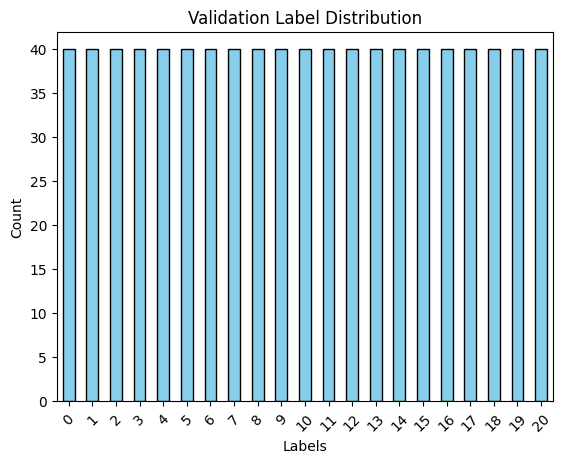

In [25]:
pd.Series(train_labels).value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Validation Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

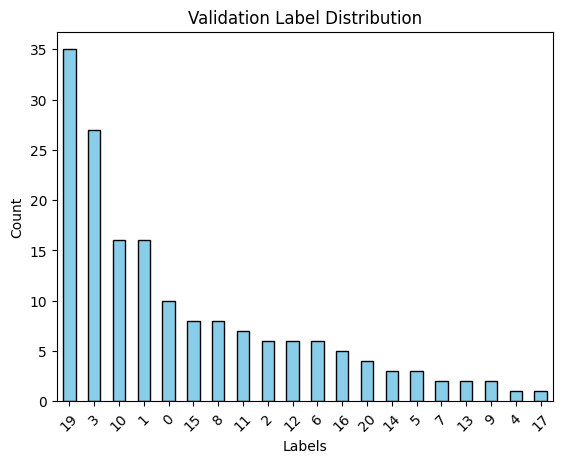

In [26]:
pd.Series(validation_labels).value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Validation Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()